In [1]:
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib.font_manager import FontProperties
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl, plt
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
#用户信息表
df1=pd.read_csv('user_profile_table.csv')
#用户申购赎回数据表
df2=pd.read_csv('user_balance_table.csv',parse_dates=['report_date'])
#余额宝14个月内的收益率表
df3=pd.read_csv('mfd_day_share_interest.csv',parse_dates=['mfd_date'])
#上海Shibor表
df4=pd.read_csv('mfd_bank_shibor.csv',parse_dates=['mfd_date'])

In [2]:
df1.head(3)

,user_id,sex,city,constellation
0,2,1,6411949,狮子座
1,12,1,6412149,摩羯座
2,22,1,6411949,双子座


In [3]:
df2.head(3)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [4]:
df3.head(3)

,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,2013-07-01,1.5787,6.307
1,2013-07-02,1.5461,6.174
2,2013-07-03,1.4670,6.034


In [5]:
df4.head(3)

,mfd_date,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y
0,2013-07-01,4.456,5.423,6.040,6.88,5.295,4.2390,4.2820,4.4125
1,2013-07-02,3.786,4.750,5.074,5.80,5.211,4.2344,4.2808,4.4070
2,2013-07-03,3.400,4.242,4.658,5.20,5.148,4.2300,4.2796,4.4022


In [6]:
df3

,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,2013-07-01,1.5787,6.307
1,2013-07-02,1.5461,6.174
2,2013-07-03,1.4670,6.034
3,2013-07-04,1.4223,5.903
4,2013-07-05,1.3845,5.739
...,...,...,...
422,2014-08-27,1.1079,4.123
423,2014-08-28,1.1043,4.116
424,2014-08-29,1.1169,4.123
425,2014-08-30,1.1206,4.134


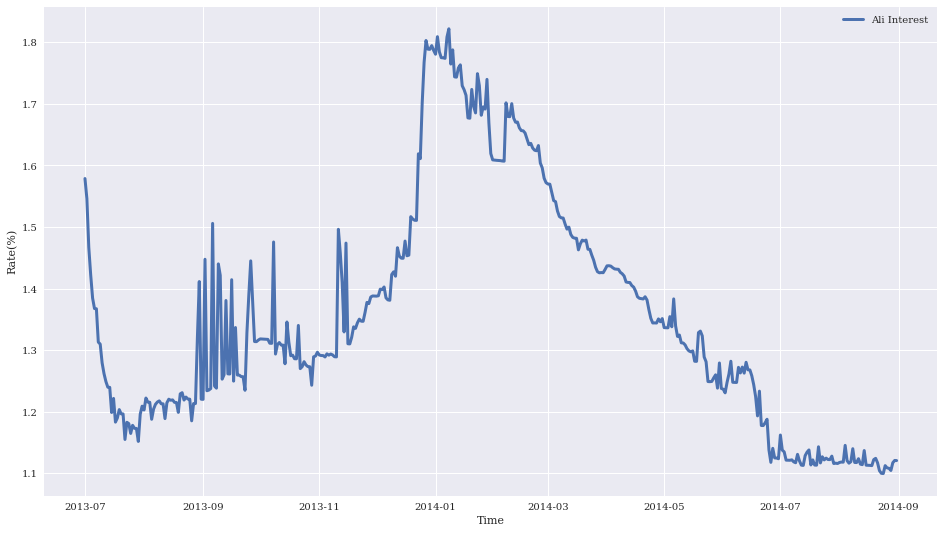

In [7]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
plt.figure(figsize=(16,9))
plt.plot(df3['mfd_date'],df3['mfd_daily_yield'],label='Ali Interest',linewidth=3)
#plt.plot(df4['mfd_date'],df4['Interest_O_N'],label='Bank',linewidth=3)
plt.ylabel('Rate(%)')
plt.xlabel('Time')
plt.legend()

In [8]:
#用户数据的情况
df2_1=df2.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
df2_2=pd.concat([df2_1.loc['2014-03'],df2_1.loc['2014-04'],df2_1.loc['2014-05'],df2_1.loc['2014-06'],df2_1.loc['2014-07'],df2_1.loc['2014-08']])

df2_2

C:\Users\Bingbing\AppData\Local\Temp/ipykernel_13676/3651384083.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2_1=df2.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()


,total_purchase_amt,total_redeem_amt
report_date,,
2014-03-01,362865580,211279011
2014-03-02,276202230,246199417
2014-03-03,505305862,513017360
2014-03-04,524146340,250562978
2014-03-05,454295491,209072753
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


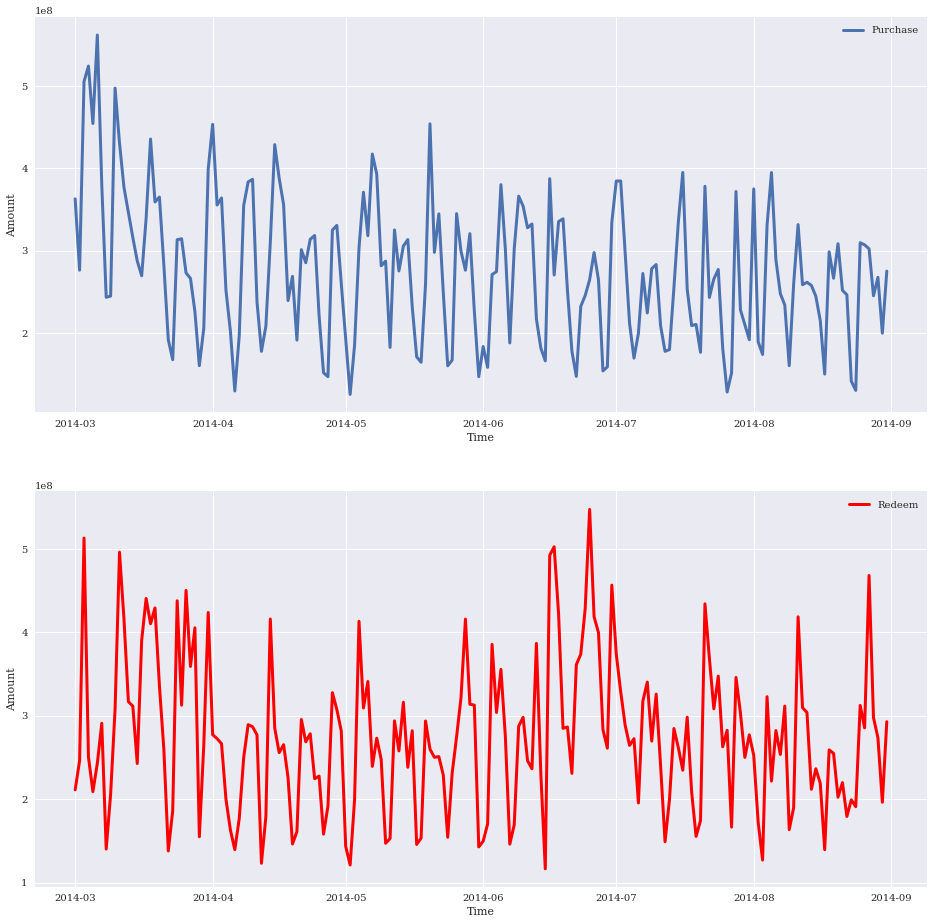

In [45]:
#需要注意的是重大节假日的影响 节假日的申购和赎回变化可能比较大 2014.4.5清明节 2014.5.1劳动节 2014.6.2端午
plt.figure(figsize=(16,16))
ax1=plt.subplot(211)
plt.plot(pd.date_range('2014-03-01',periods=len(df2_2)),df2_2['total_purchase_amt'],label='Purchase',linewidth=3)
#plt.plot(pd.date_range('2014-04-01',periods=len(df2_2)),df2_2['total_redeem_amt'],label='Purchase',linewidth=3)
plt.ylabel('Amount')
plt.xlabel('Time')
plt.legend()
ax2=plt.subplot(212)

#plt.plot(pd.date_range('2014-04-01',periods=len(df2_2)),df2_2['total_purchase_amt'],label='Purchase',linewidth=3)
plt.plot(pd.date_range('2014-03-01',periods=len(df2_2)),df2_2['total_redeem_amt'],label='Redeem',linewidth=3,c='r')
plt.ylabel('Amount')
plt.xlabel('Time')
plt.legend()

In [10]:
'''
使用LSTM神经网络进行predict
'''
#首先是对数据的处理
#数据归一：最大最小值的归一，将指定的数据规范到-1，1之间
scaler1 = MinMaxScaler(feature_range=(-1, 1))
train1 = scaler1.fit_transform(df2_2['total_purchase_amt'].values.reshape(-1,1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
train2 = scaler2.fit_transform(df2_2['total_redeem_amt'].values.reshape(-1,1))
#使用之前预测股票的code，构造数据集
def load_data(stock, look_back):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size =0
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]
look_back = 30
x_train, y_train, x_test, y_test = load_data(train1, look_back)
x_train2, y_train2, x_test2, y_test2 = load_data(train2, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (154, 29, 1)
y_train.shape =  (154, 1)
x_test.shape =  (0, 29, 1)
y_test.shape =  (0, 1)


In [11]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
x_train2 = torch.from_numpy(x_train2).type(torch.Tensor)
x_test2 = torch.from_numpy(x_test2).type(torch.Tensor)
y_train2 = torch.from_numpy(y_train2).type(torch.Tensor)
y_test2 = torch.from_numpy(y_test2).type(torch.Tensor)
print(y_train.size(),x_train.size())

torch.Size([154, 1]) torch.Size([154, 29, 1])


In [12]:
from  tqdm import tqdm
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,drop_p):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,dropout=drop_p, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim,int( hidden_dim*0.3))
        self.fc2 = nn.Linear(int(0.3*hidden_dim), output_dim)
        self.dropout=nn.Dropout(drop_p)
        self.loss_list=[]
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out=self.fc1(out)
        out = self.fc2(out[:, -1, :])
        return out
    def train(self,x_train,y_train,num_epochs=400):
        self.loss_list=[]
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
        hist = np.zeros(num_epochs)
        start_time = time.time()
        lstm = []
        with tqdm(range(num_epochs),desc='Training:') as tbar:
            for i in tbar:
                y_train_pred = model(x_train)

                loss = criterion(y_train_pred, y_train)
                # print("Epoch ", t, "MSE: ", loss.item())
                self.loss_list.append(loss.item())
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                tbar.set_postfix(loss=loss.item())
                tbar.update()

        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
    def predict(self,data):
        result=model(data)
        return result
    def plot_loss(self):
        plt.figure(figsize=(16,9))
        plt.plot(range(len(self.loss_list)),self.loss_list,linewidth=3)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

In [48]:
model = LSTM(input_dim=1, hidden_dim=64, output_dim=1, num_layers=2,drop_p=0.2)
model.train(x_train,y_train)
model2=LSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2,drop_p=0.2)
model2.train(x_train2,y_train2)

Training:: 100%|██████████| 400/400 [00:35<00:00, 11.37it/s, loss=0.00371]


Training time: 35.16708779335022


Training:: 100%|██████████| 400/400 [00:33<00:00, 11.86it/s, loss=0.000476]

Training time: 33.72093057632446


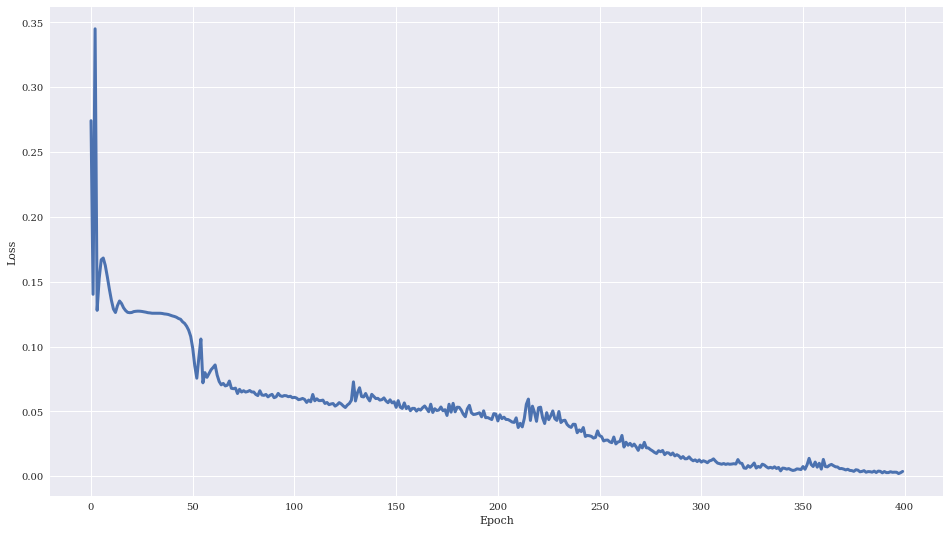

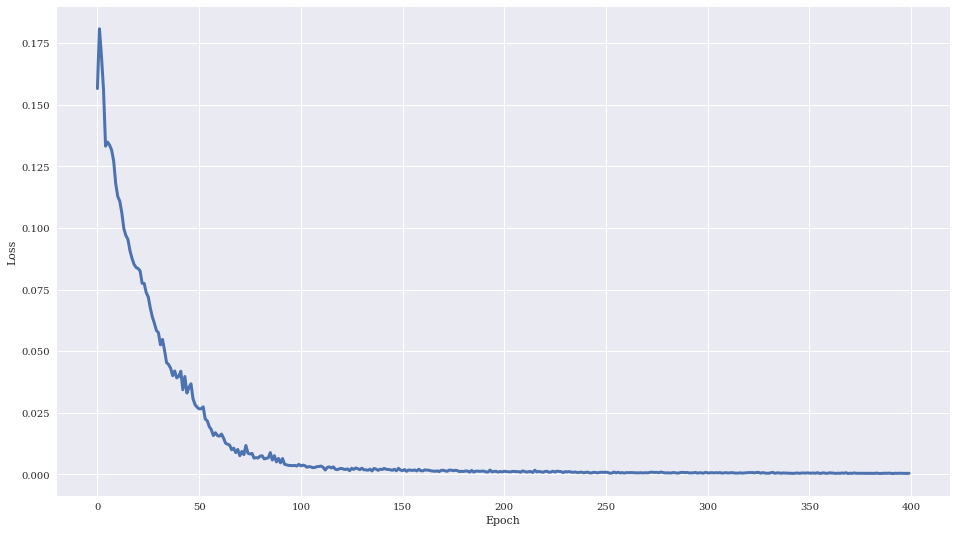

In [49]:
model.plot_loss()
model2.plot_loss()

In [27]:
def predict_2(x_train,model):
    #截取最后一个30天的数据
    predict=model.predict(x_train[-2:-1,:,:])
    each=x_train[-2:-1,:,:].reshape(-1)
    predict_30=[]
    for i in tqdm(range(30)):
        #实现类似于滑动窗口的效果
        predict=model.predict(each.reshape(1,29,1))
        each=np.append(each.reshape(-1)[1:].numpy(),float(predict))
        each=torch.from_numpy(each.reshape(1,29,1)).type(torch.Tensor)
        predict_30.append(float(predict))
    return predict_30

100%|██████████| 30/30 [00:00<00:00, 142.86it/s]


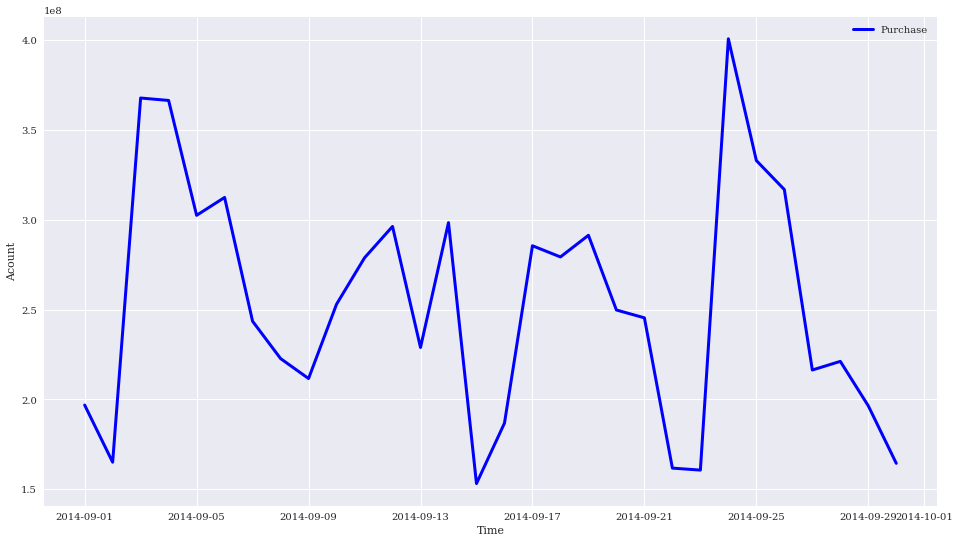

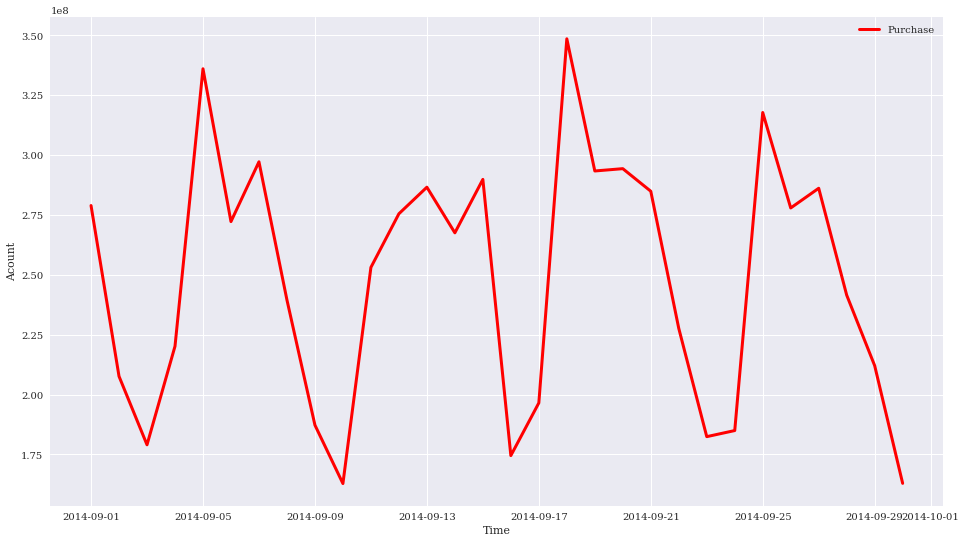

In [57]:
purchase_predict=predict_2(x_train,model)
redeem_predict=predict_2(x_train2,model2)
purchase_predict=scaler1.inverse_transform(np.array(purchase_predict).reshape(-1,1)).reshape(-1)
redeem_predict=scaler1.inverse_transform(np.array(redeem_predict).reshape(-1,1)).reshape(-1)
time1=pd.date_range('20140901',periods=30)
time2=[i.strftime('%Y%m%d') for i in time1]
submit_df=pd.DataFrame([purchase_predict,redeem_predict])
submit_df=pd.DataFrame(submit_df.values.T)
submit_df.index=time2
submit_df.to_csv('tc_comp_predict_table.csv')
def plot_image(list,label,ylabel,xlabel,c):
    plt.figure(figsize=(16,9))
    plt.plot(pd.date_range('2014-09-01',periods=30),list,linewidth=3,label=label,c=c)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
plot_image(purchase_predict,'Purchase','Acount','Time','b')
plot_image(redeem_predict,'Purchase','Acount','Time','r')

In [29]:
'''
使用Prophet时间序列算法预测
'''
#使用Prophet时间序列直接预测
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from sklearn import preprocessing
import time
import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [54]:
#training dataset,testing dataset
train_df1_1=pd.DataFrame({'ds':pd.date_range('2014-03-01',periods=len(train1)),'y':train1.reshape(-1)})
train_df1_2=pd.DataFrame({'ds':pd.date_range('2014-03-01',periods=len(train2)),'y':train2.reshape(-1)})
train_df1_1.head(1)

,ds,y
0,2014-03-01,0.088457


In [31]:
# import itertools
# from prophet.diagnostics import cross_validation
# from prophet.diagnostics import performance_metrics
# param_grid = {
#     'changepoint_prior_scale': [0.6, 0.7, 0.8 , 0.9,1.0],
#     'interval_width': [0.6, 0.7, 0.8 , 0.9,1.0],
# }
#
# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# mses = []  # Store the RMSEs for each params here
#
# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params,changepoint_range=1).fit(train_df1_1)  # Fit model with given params
#     df_cv = cross_validation(m,horizon='14 days',parallel='processes')
#     #该参数rolling_window指定在每个滚动窗口中使用的预测比例。默认为 0.1，对应df_cv每个窗口包含的行数的 10%
#     df_p = performance_metrics(df_cv, rolling_window=0.2)
#     mses.append(df_p['mse'].values[0])
#
# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['mse'] = mses
# print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


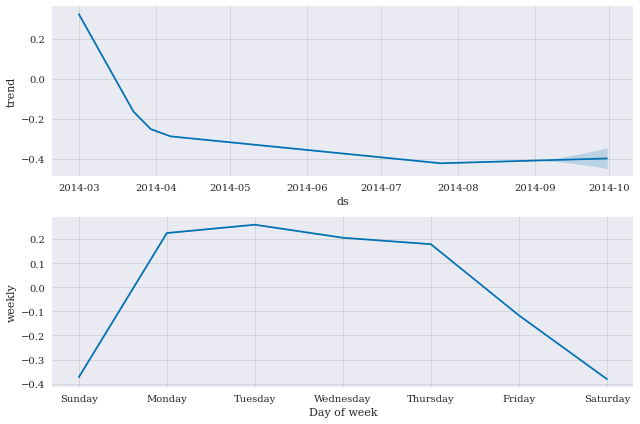

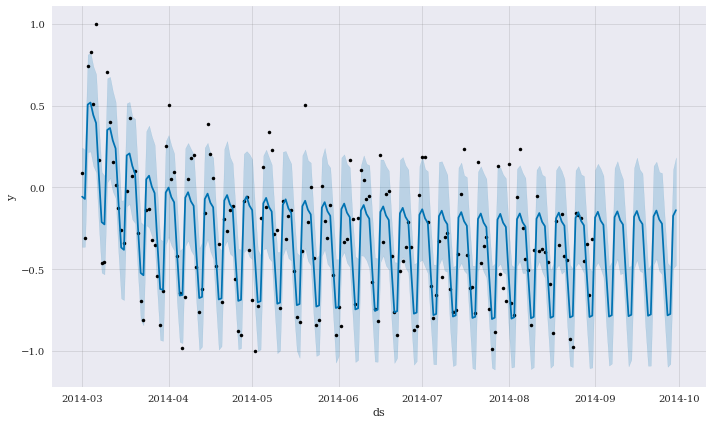

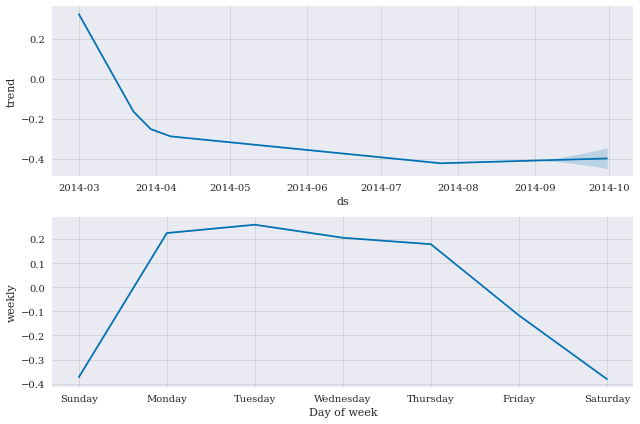

In [55]:
m=Prophet(changepoint_prior_scale=1.0,interval_width=0.8,changepoint_range=1).fit(train_df1_1)
future1=m.make_future_dataframe(periods=30,freq='D')
forecast1=m.predict(future1)
m.plot(forecast1)
m.plot_components(forecast1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


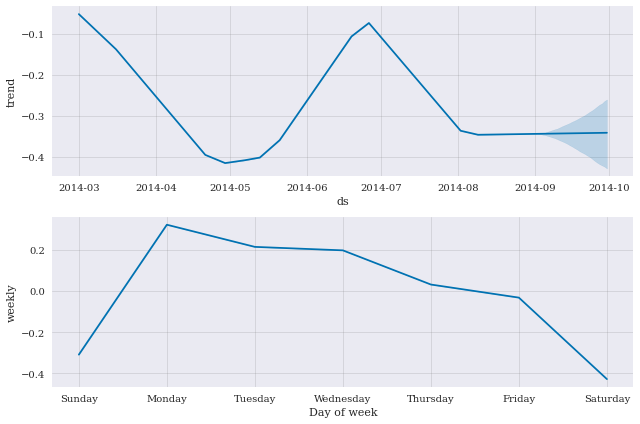

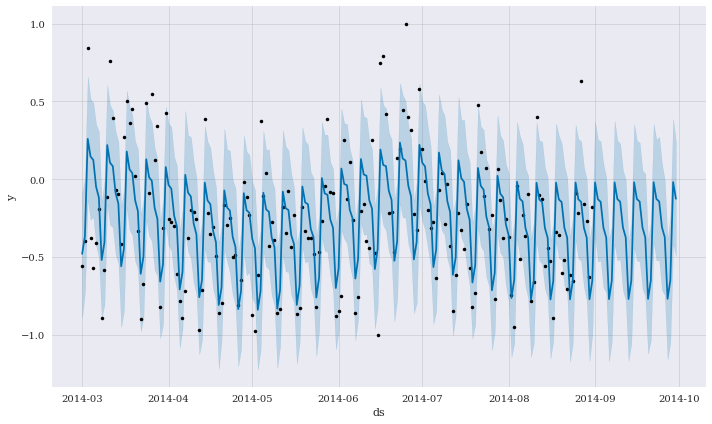

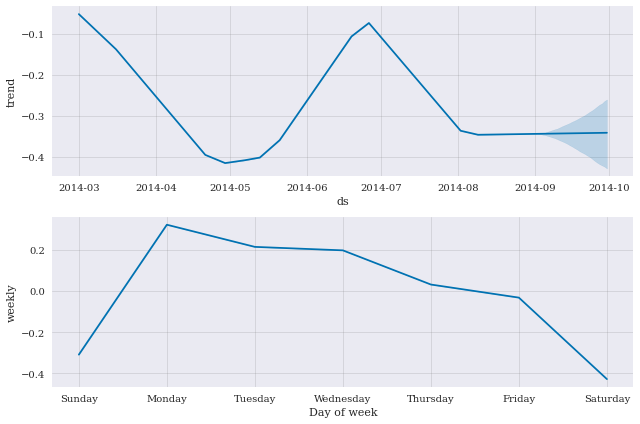

In [56]:
m2=Prophet(changepoint_prior_scale=1.0,interval_width=0.8,changepoint_range=1).fit(train_df1_2)
future2=m2.make_future_dataframe(periods=30,freq='D')
forecast2=m2.predict(future2)
m2.plot(forecast2)
m2.plot_components(forecast2)

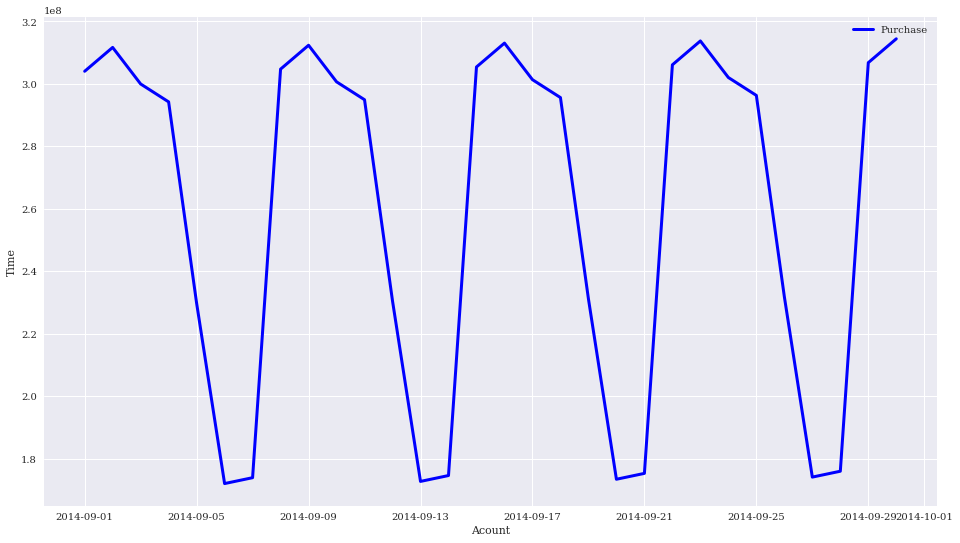

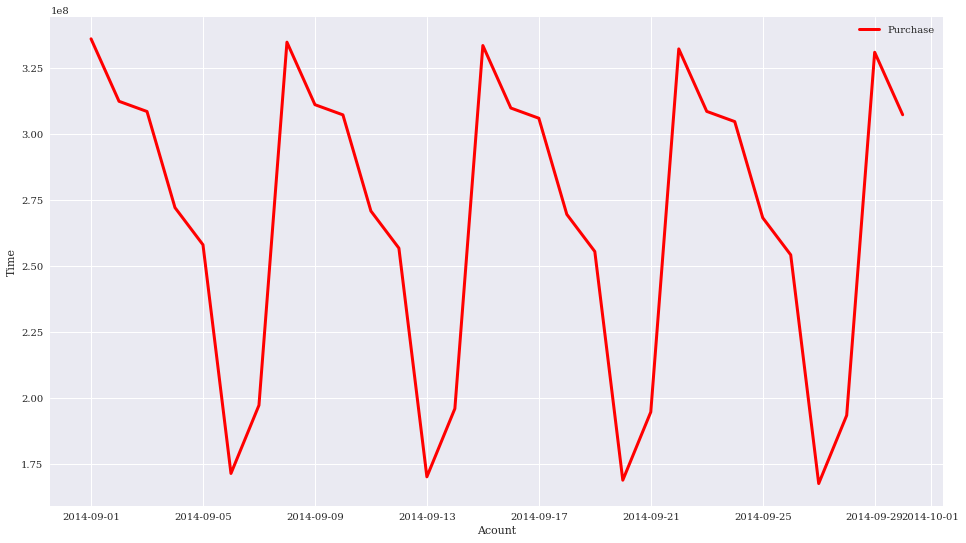

In [53]:
purchase_predict=scaler1.inverse_transform(np.array(forecast1['yhat'][-30:]).reshape(-1,1)).reshape(-1)
redeem_predict=scaler1.inverse_transform(np.array(forecast2['yhat'][-30:]).reshape(-1,1)).reshape(-1)
submit_df=pd.DataFrame([purchase_predict,redeem_predict])
submit_df=pd.DataFrame(submit_df.values.T)
submit_df.index=time2
submit_df.to_csv('tc_comp_predict_table.csv')
def plot_image(list,label,xlabel,ylabel,c):
    plt.figure(figsize=(16,9))
    plt.plot(pd.date_range('2014-09-01',periods=30),list,linewidth=3,label=label,c=c)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
plot_image(purchase_predict,'Purchase','Acount','Time','b')
plot_image(redeem_predict,'Purchase','Acount','Time','r')

In [34]:
forecast['yhat'][-30:]

184   -0.034928
185   -0.143446
186   -0.161167
187   -0.328118
188   -0.392597
189   -0.789692
190   -0.671285
191   -0.040776
192   -0.149294
193   -0.167015
194   -0.333966
195   -0.398445
196   -0.795540
197   -0.677133
198   -0.046624
199   -0.155142
200   -0.172864
201   -0.339814
202   -0.404293
203   -0.801388
204   -0.682981
205   -0.052472
206   -0.160990
207   -0.178712
208   -0.345662
209   -0.410141
210   -0.807236
211   -0.688829
212   -0.058320
213   -0.166838
Name: yhat, dtype: float64

array([2.38487971e+08, 1.64274544e+08, 2.05272128e+08, 3.82891172e+08,
       2.66437274e+08, 2.99902008e+08, 2.81262894e+08, 2.15928515e+08,
       1.58945609e+08, 1.97788331e+08, 2.30450181e+08, 3.11195221e+08,
       2.93979587e+08, 3.28380093e+08, 1.95061748e+08, 1.76409415e+08,
       1.85270669e+08, 3.30699593e+08, 3.11720910e+08, 3.28905741e+08,
       2.51973166e+08, 2.20906384e+08, 1.51401316e+08, 2.13248901e+08,
       3.67686416e+08, 2.78460647e+08, 3.02138130e+08, 2.44393063e+08,
       1.52957895e+08, 2.37871661e+08])

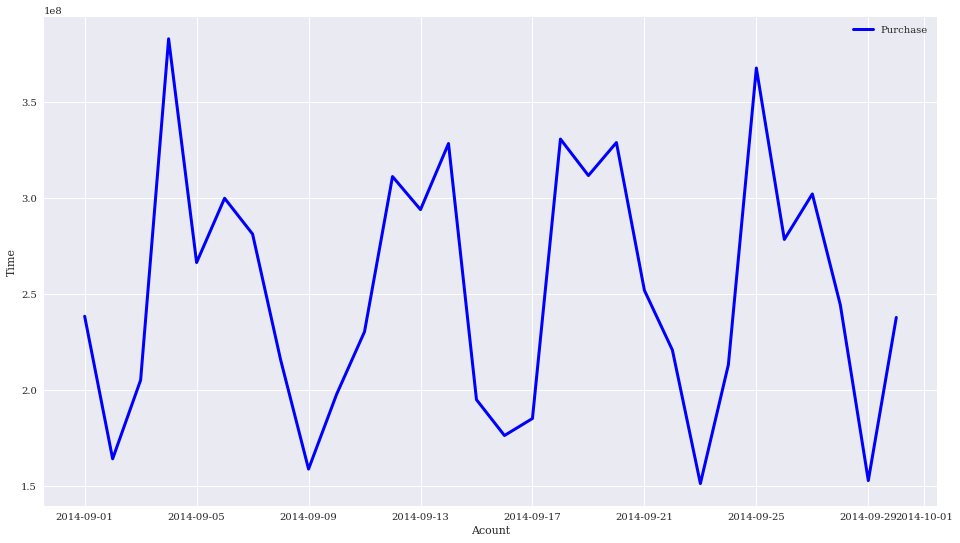

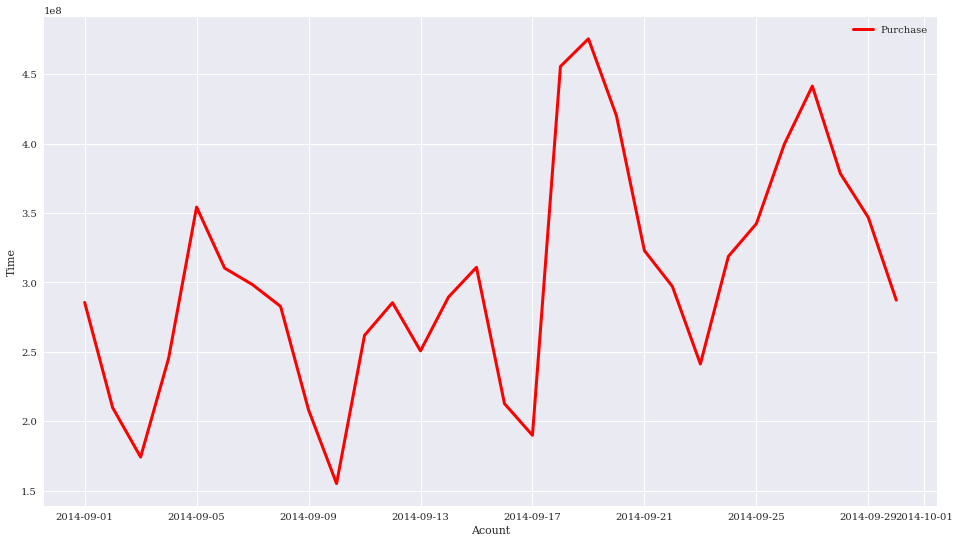

In [35]:
def plot_image(list,label,xlabel,ylabel,c):
    plt.figure(figsize=(16,9))
    plt.plot(pd.date_range('2014-09-01',periods=30),list,linewidth=3,label=label,c=c)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
plot_image(purchase_predict,'Purchase','Acount','Time','b')
plot_image(redeem_predict,'Purchase','Acount','Time','r')
np.array(purchase_predict)
